# Setup

In [1]:
#load libraries
import pandas as pd
import time
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (11, 8) #default plot size
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 
from nltk.corpus import wordnet
from nltk.tokenize import RegexpTokenizer, sent_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [2]:
#load train file
df_train = pd.read_csv('../IOD_CS/train_set.csv')

In [3]:
#load validation file
df_val = pd.read_csv('../IOD_CS/validation_set.csv')

In [4]:
#load test file
df_test = pd.read_csv('../IOD_CS/test_set.csv')

In [5]:
df_train.head(5)

,id,person_name,nine_box_category,feedback,adjusted,reviewed,label,feedback_len,num_of_sent,performance_class,potential_class,feedback_clean,data_type
0,1,John Doe,"Category 1: 'Risk' (Low performance, Low poten...",John has not progressed in his position. He is...,False,True,0,287,5,0,0,john ha not progressed in his position he is c...,train
1,10045,Douglas Henry,"Category 1: 'Risk' (Low performance, Low poten...",Douglas Henry has been having trouble in all a...,False,False,0,430,6,0,0,douglas henry ha been having trouble in all ar...,train
2,10044,Douglas Henry,"Category 1: 'Risk' (Low performance, Low poten...",Douglas has a lot to work on and areas to grow...,False,False,0,290,4,0,0,douglas ha a lot to work on and area to grow i...,train
3,10005,Freddie Davies,"Category 1: 'Risk' (Low performance, Low poten...","Freddie is a nice guy, but his performance and...",False,True,0,418,5,0,0,freddie is a nice guy but his performance and ...,train
4,10004,Freddie Davies,"Category 1: 'Risk' (Low performance, Low poten...",Freddie has been quite disappointing this quar...,False,False,0,449,4,0,0,freddie ha been quite disappointing this quart...,train


In [6]:
df_val.head(5)

,id,person_name,nine_box_category,feedback,adjusted,reviewed,label,feedback_len,num_of_sent,performance_class,potential_class,feedback_clean,data_type
0,10046,Douglas Henry,"Category 1: 'Risk' (Low performance, Low poten...",Douglas Henry has not performed at a high leve...,False,False,0,321,4,0,0,douglas henry ha not performed at a high level...,val
1,10002,Freddie Davies,"Category 1: 'Risk' (Low performance, Low poten...",Freddie Davies onboarded the team a few months...,False,False,0,502,4,0,0,freddie davy onboarded the team a few month ag...,val
2,10001,Freddie Davies,"Category 1: 'Risk' (Low performance, Low poten...",Freddie Davies needs lots of improvement in hi...,False,False,0,265,2,0,0,freddie davy need lot of improvement in his wo...,val
3,86,Broderick Hays,"Category 1: 'Risk' (Low performance, Low poten...",Broderick is not doing so well. His work on a ...,False,False,0,226,4,0,0,broderick is not doing so well his work on a d...,val
4,84,Broderick Hays,"Category 1: 'Risk' (Low performance, Low poten...",Broderick is always such a wildcard to put in ...,False,False,0,514,4,0,0,broderick is always such a wildcard to put in ...,val


In [7]:
df_train.drop(['adjusted'], axis=1, inplace=True)
df_val.drop(['adjusted'], axis=1, inplace=True)

In [8]:
df_test.head()

,id,person_name,nine_box_category,feedback,updated,reviewed,label,performance_class,potential_class,feedback_clean
0,20051,Lacey Howard,"Category 1: 'Risk' (Low performance, Low poten...",Lacey's performance has been sub standard in t...,True,True,0,0,0,laceys performance ha been sub standard in the...
1,20214,Jon Fischer,"Category 1: 'Risk' (Low performance, Low poten...",Jon Fischer has not been instrumental so far a...,False,True,0,0,0,jon fischer ha not been instrumental so far at...
2,20213,Jon Fischer,"Category 1: 'Risk' (Low performance, Low poten...",Jon fisher is a disappointment. Lazy and compl...,False,True,0,0,0,jon fisher is a disappointment lazy and compla...
3,20212,Jon Fischer,"Category 1: 'Risk' (Low performance, Low poten...",Jon has been really difficult to work with for...,False,True,0,0,0,jon ha been really difficult to work with for ...
4,20186,Johanna Duke,"Category 1: 'Risk' (Low performance, Low poten...",Despite Johanna Duke appearing to be a capable...,True,True,0,0,0,despite johanna duke appearing to be a capable...


In [9]:
df_test['data_type'] = 'test'

In [10]:
df_test.sample(5)

,id,person_name,nine_box_category,feedback,updated,reviewed,label,performance_class,potential_class,feedback_clean,data_type
126,20192,Andrew Grant,Category 6: 'High Performer' (High performance...,Andrew Grant is an able bodied member of the w...,True,True,5,2,1,andrew grant is an able bodied member of the w...,test
107,20210,Patrick Adams,Category 5: 'Core Player' (Moderate performanc...,Patrick is a team player and a supportive cowo...,True,True,4,1,1,patrick is a team player and a supportive cowo...,test
71,20138,Xavier Mcdowell,Category 3: 'Solid Performer' (High performanc...,Xavier is exceptional on the technology side o...,False,True,2,2,0,xavier is exceptional on the technology side o...,test
16,20059,Amy Jones,"Category 1: 'Risk' (Low performance, Low poten...",Amy Jones needs to become a better player. She...,True,True,0,0,0,amy jones need to become a better player she g...,test
25,20149,Niamh Walsh,Category 2: 'Average performer' (Moderate perf...,Niamh's performance has been average for the o...,True,True,1,1,0,niamhs performance ha been average for the ong...,test


In [11]:
df_combined = pd.concat([df_train, df_val, df_test])

In [12]:
df_combined.head(5)

,id,person_name,nine_box_category,feedback,reviewed,label,feedback_len,num_of_sent,performance_class,potential_class,feedback_clean,data_type,updated
0,1,John Doe,"Category 1: 'Risk' (Low performance, Low poten...",John has not progressed in his position. He is...,True,0,287.0,5.0,0,0,john ha not progressed in his position he is c...,train,NaN
1,10045,Douglas Henry,"Category 1: 'Risk' (Low performance, Low poten...",Douglas Henry has been having trouble in all a...,False,0,430.0,6.0,0,0,douglas henry ha been having trouble in all ar...,train,NaN
2,10044,Douglas Henry,"Category 1: 'Risk' (Low performance, Low poten...",Douglas has a lot to work on and areas to grow...,False,0,290.0,4.0,0,0,douglas ha a lot to work on and area to grow i...,train,NaN
3,10005,Freddie Davies,"Category 1: 'Risk' (Low performance, Low poten...","Freddie is a nice guy, but his performance and...",True,0,418.0,5.0,0,0,freddie is a nice guy but his performance and ...,train,NaN
4,10004,Freddie Davies,"Category 1: 'Risk' (Low performance, Low poten...",Freddie has been quite disappointing this quar...,False,0,449.0,4.0,0,0,freddie ha been quite disappointing this quart...,train,NaN


In [13]:
df_combined.describe()

,id,label,feedback_len,num_of_sent,performance_class,potential_class
count,997.000000,997.000000,772.000000,772.000000,997.000000,997.000000
mean,6454.894684,3.820461,335.242228,4.204663,1.019057,0.933801
std,7992.386895,2.657274,108.170278,0.773812,0.811958,0.802626
min,1.000000,0.000000,151.000000,2.000000,0.000000,0.000000
25%,293.000000,2.000000,251.000000,4.000000,0.000000,0.000000
50%,606.000000,4.000000,319.000000,4.000000,1.000000,1.000000
75%,10183.000000,6.000000,405.000000,5.000000,2.000000,2.000000
max,20233.000000,8.000000,599.000000,8.000000,2.000000,2.000000


In [14]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 997 entries, 0 to 224
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 997 non-null    int64  
 1   person_name        997 non-null    object 
 2   nine_box_category  997 non-null    object 
 3   feedback           997 non-null    object 
 4   reviewed           997 non-null    bool   
 5   label              997 non-null    int64  
 6   feedback_len       772 non-null    float64
 7   num_of_sent        772 non-null    float64
 8   performance_class  997 non-null    int64  
 9   potential_class    997 non-null    int64  
 10  feedback_clean     997 non-null    object 
 11  data_type          997 non-null    object 
 12  updated            225 non-null    object 
dtypes: bool(1), float64(2), int64(4), object(6)
memory usage: 102.2+ KB


In [15]:
#drop columns not required
df_combined.drop(['nine_box_category', 'reviewed', 'label', 'feedback_len','num_of_sent','feedback_clean','updated'], axis=1, inplace=True)

In [16]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 997 entries, 0 to 224
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 997 non-null    int64 
 1   person_name        997 non-null    object
 2   feedback           997 non-null    object
 3   performance_class  997 non-null    int64 
 4   potential_class    997 non-null    int64 
 5   data_type          997 non-null    object
dtypes: int64(3), object(3)
memory usage: 54.5+ KB


# EDA

In [17]:
df_combined['person_name'].value_counts()

Graysen Sellers      11
Morgan Butler        10
Madison Cleveland    10
Eloise Foster        10
Angelica Peterson    10
                     ..
Ashton Owen           2
Lauren Baker          2
Teagan Pate           2
Azariah Mcmillan      2
Jimmy Curry           1
Name: person_name, Length: 205, dtype: int64

In [18]:
df_combined.groupby(['person_name'])['data_type'].nunique()

person_name
Addison Cohen      2
Alecia Keys        2
Alex Watts         1
Alfie Wright       2
Alina Britt        1
                  ..
Xavier Mcdowell    1
Yahir Harvey       2
Zachary Doyle      2
Zachary Turner     1
Zoe White          1
Name: data_type, Length: 205, dtype: int64

In [19]:
#function to categorize & label each sample
def pre_label(df):
  df['total_score'] = df['performance_class'] + df['potential_class']
  
  #categorize total score into 5 categories: observe/exit = 0 |observe = 1| develop = 2 | develop/stretch=3 | stretch=4
  df['label'] = 2 #develop
  df.loc[df['total_score'] == 0, 'label'] = 0 #observe/exit
  df.loc[df['total_score'] == 1, 'label'] = 1 #observe
  df.loc[df['total_score'] == 3, 'label'] = 3 #develop/stretch
  df.loc[df['total_score'] == 4, 'label'] = 4 #stretch
  
  return df

In [20]:
df_combined = pre_label(df_combined)

In [21]:
df_combined.head(5)

,id,person_name,feedback,performance_class,potential_class,data_type,total_score,label
0,1,John Doe,John has not progressed in his position. He is...,0,0,train,0,0
1,10045,Douglas Henry,Douglas Henry has been having trouble in all a...,0,0,train,0,0
2,10044,Douglas Henry,Douglas has a lot to work on and areas to grow...,0,0,train,0,0
3,10005,Freddie Davies,"Freddie is a nice guy, but his performance and...",0,0,train,0,0
4,10004,Freddie Davies,Freddie has been quite disappointing this quar...,0,0,train,0,0


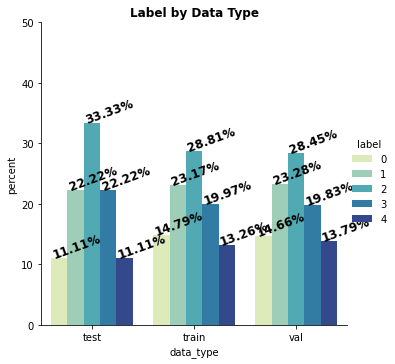

In [22]:
#plot counts of 'label' for each cat based on 'data_type'
a,b = 'data_type', 'label'
tmp = df_combined.groupby(a)[b].value_counts(normalize=True).mul(100).rename('percent').reset_index()

chart = sns.catplot(x=a, y='percent', hue=b, kind='bar', data=tmp, palette='YlGnBu')
chart.ax.set_ylim(0,50)
chart.ax.set_title('Label by Data Type', size='large', fontweight='bold');
for p in chart.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    chart.ax.text(txt_x, txt_y, txt, fontweight='bold',size='large',rotation=20)

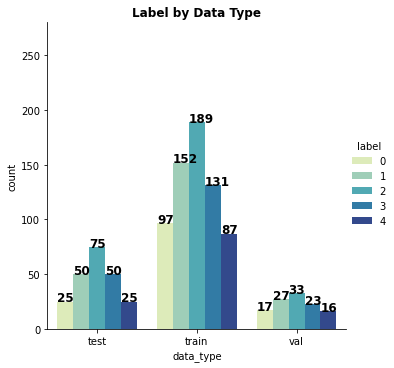

In [23]:
#plot counts of 'label' for each cat based on 'data_type'
a,b = 'data_type', 'label'
tmp = df_combined.groupby(a)[b].value_counts().rename('count').reset_index()

chart = sns.catplot(x=a, y='count', hue=b, kind='bar', data=tmp, palette='YlGnBu')
chart.ax.set_ylim(0,280)
chart.ax.set_title('Label by Data Type', size='large', fontweight='bold');

for p in chart.ax.patches:
    txt = str(int(p.get_height()))
    txt_x = p.get_x()
    txt_y = p.get_height()
    chart.ax.text(txt_x, txt_y, txt, fontweight='bold',size='large')

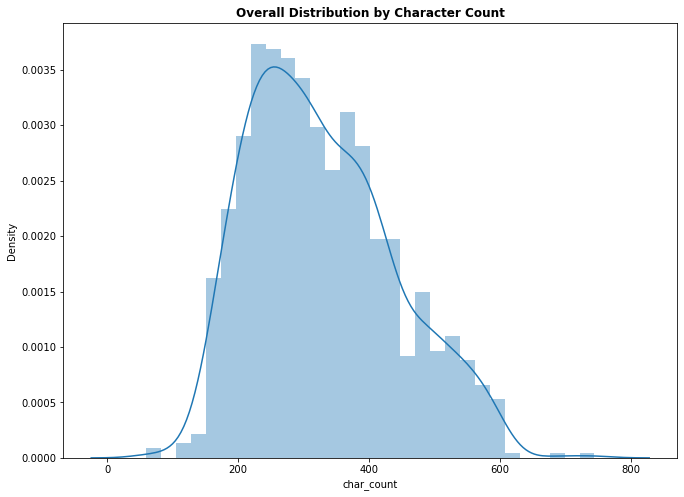

In [24]:
#plot distribution for character count
df_combined['char_count'] = df_combined['feedback'].str.len()
chart = sns.distplot(df_combined['char_count'], bins = 30)
chart.set_title('Overall Distribution by Character Count',fontweight='bold',size='large');

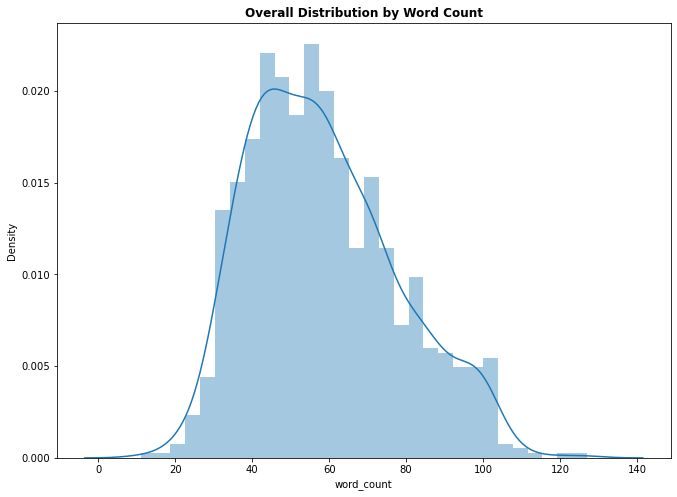

In [25]:
#plot distribution for word count
df_combined['word_count'] = df_combined['feedback'].apply(lambda x: len(str(x).split()))
chart = sns.distplot(df_combined['word_count'], bins = 30)
chart.set_title('Overall Distribution by Word Count',fontweight='bold',size='large');

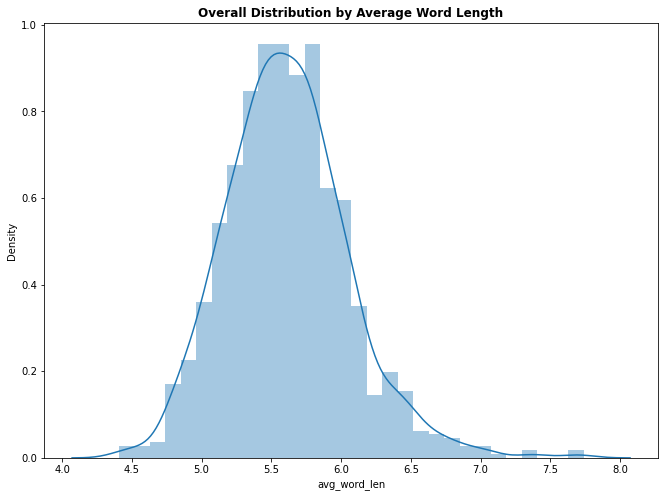

In [26]:
#plot distribution for average word length
df_combined['avg_word_len'] = df_combined['char_count']/df_combined['word_count']
chart = sns.distplot(df_combined['avg_word_len'], bins = 30)
chart.set_title('Overall Distribution by Average Word Length',fontweight='bold',size='large');

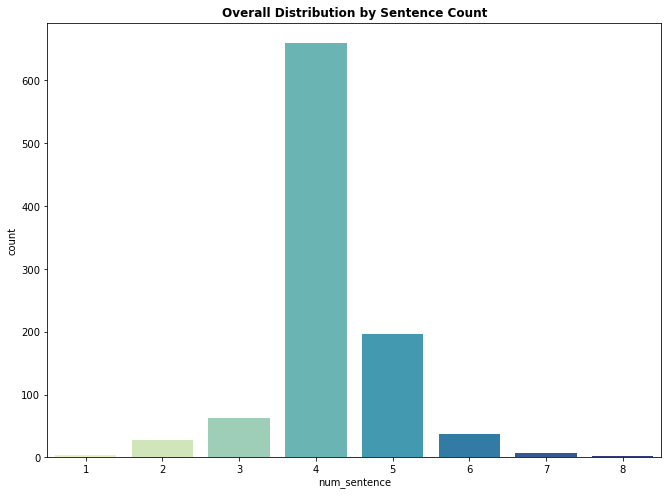

In [27]:
#plot distribution for sentence count
df_combined['num_sentence'] = [len(list(sent_tokenize(text))) for text in df_combined['feedback']]
chart = sns.countplot(df_combined['num_sentence'], palette='YlGnBu')
chart.set_title('Overall Distribution by Sentence Count',fontweight='bold',size='large');

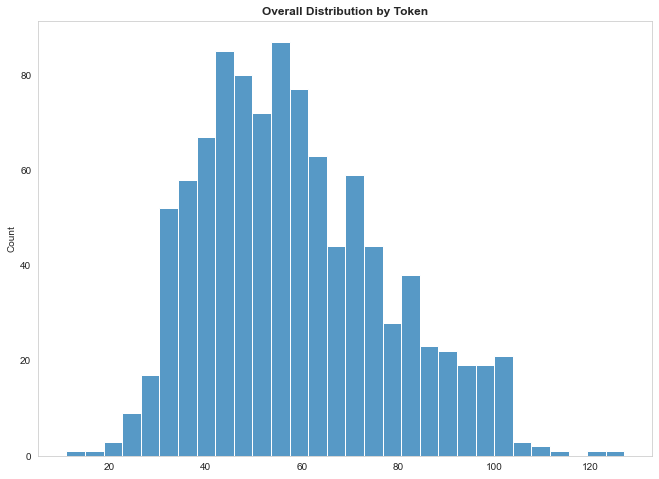

In [28]:
#check token size
sns.set_style("whitegrid", {'axes.grid' : False})
seq_len = [len(i.split()) for i in df_combined['feedback']]

chart = sns.histplot(pd.Series(seq_len), bins = 30)
chart.set_title('Overall Distribution by Token',fontweight='bold',size='large');

In [29]:
#split cleaned data back to train/val/test dataframes
train = df_combined.loc[df_combined['data_type']=='train'].copy()
val = df_combined.loc[df_combined['data_type']=='val'].copy()
test = df_combined.loc[df_combined['data_type']=='test'].copy()

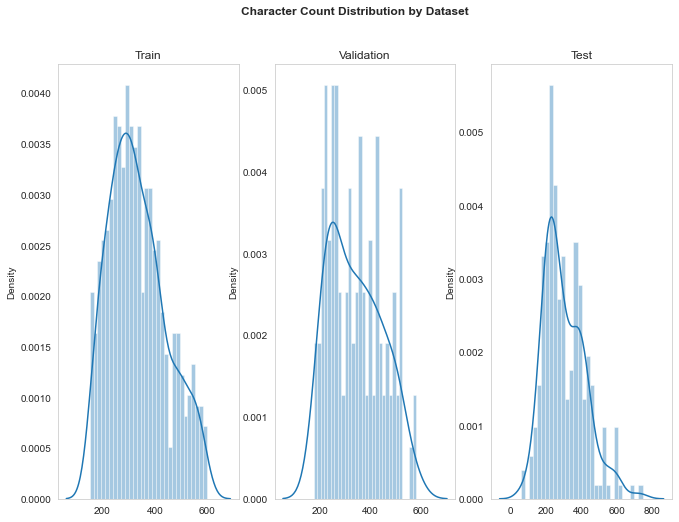

In [30]:
#plot distribution for character count
fig, axes = plt.subplots(1,3)
chart = sns.distplot(x=train['char_count'], bins = 30, ax=axes[0]).set(title='Train')
chart = sns.distplot(x=val['char_count'], bins = 30, ax=axes[1]).set(title='Validation')
chart = sns.distplot(x=test['char_count'], bins = 30, ax=axes[2]).set(title='Test')
plt.suptitle('Character Count Distribution by Dataset',fontweight='bold',size='large');

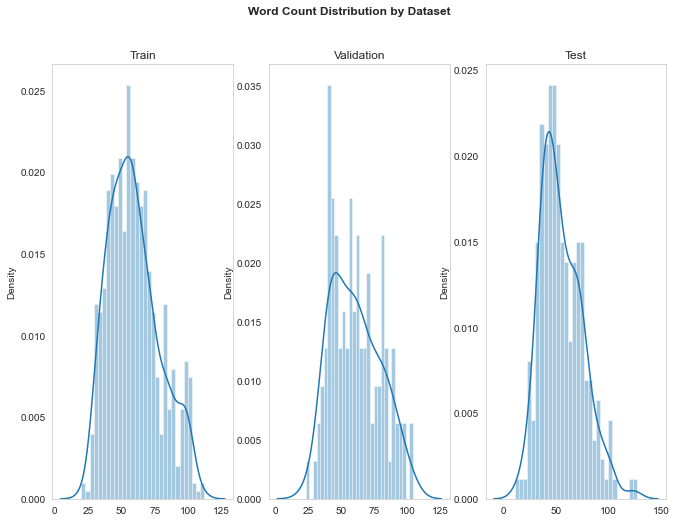

In [31]:
#plot distribution for word count
fig, axes = plt.subplots(1,3)
chart = sns.distplot(x=train['word_count'], bins = 30, ax=axes[0]).set(title='Train')
chart = sns.distplot(x=val['word_count'], bins = 30, ax=axes[1]).set(title='Validation')
chart = sns.distplot(x=test['word_count'], bins = 30, ax=axes[2]).set(title='Test')
plt.suptitle('Word Count Distribution by Dataset',fontweight='bold',size='large');

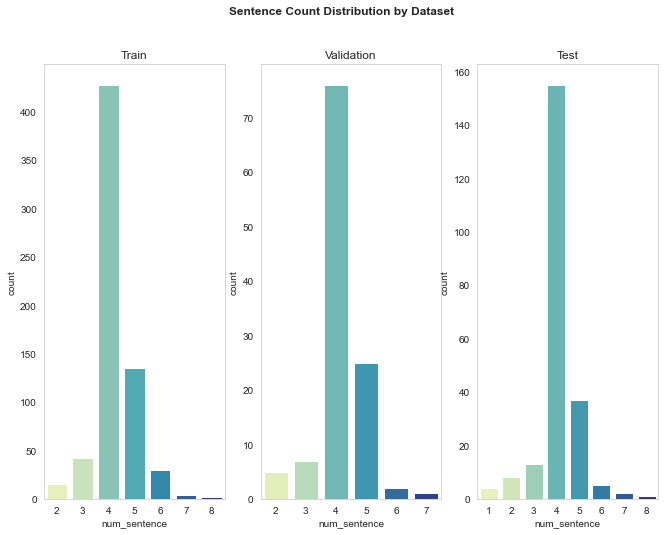

In [32]:
#plot distribution for sentence count
fig, axes = plt.subplots(1,3)
chart = sns.countplot(x=train['num_sentence'], palette='YlGnBu', ax=axes[0]).set(title='Train')
chart = sns.countplot(x=val['num_sentence'], palette='YlGnBu', ax=axes[1]).set(title='Validation')
chart = sns.countplot(x=test['num_sentence'], palette='YlGnBu', ax=axes[2]).set(title='Test')
plt.suptitle('Sentence Count Distribution by Dataset',fontweight='bold',size='large');

# Cleaning

In [33]:
def clean_text(raw):
    # Intantiate lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # Remove non-letter characters
    letters_only = re.sub('[^a-zA-z]', ' ', raw)
    
    # Convert string to lower case
    lower_only = letters_only.lower().split()
    
    # Lemmatize words in lower_only string
    lemm_words = [lemmatizer.lemmatize(i) for i in lower_only if i not in set(stopwords.words('english'))]
    
    # Return cleaned words if not in stopwords
    words = [w for w in lemm_words]
    
    # Return clean words and join with space
    return(" ".join(words))

In [34]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chani\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chani\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [35]:
df_combined['feedback_clean'] = df_combined['feedback'].apply(clean_text)
df_combined.head()

,id,person_name,feedback,performance_class,potential_class,data_type,total_score,label,char_count,word_count,avg_word_len,num_sentence,feedback_clean
0,1,John Doe,John has not progressed in his position. He is...,0,0,train,0,0,287,48,5.979167,5,john progressed position continuously late lea...
1,10045,Douglas Henry,Douglas Henry has been having trouble in all a...,0,0,train,0,0,430,80,5.375000,6,douglas henry trouble area job rarely arrives ...
2,10044,Douglas Henry,Douglas has a lot to work on and areas to grow...,0,0,train,0,0,290,59,4.915254,4,douglas lot work area grow work lack drive acc...
3,10005,Freddie Davies,"Freddie is a nice guy, but his performance and...",0,0,train,0,0,418,84,4.976190,5,freddie nice guy performance potential level v...
4,10004,Freddie Davies,Freddie has been quite disappointing this quar...,0,0,train,0,0,449,74,6.067568,4,freddie quite disappointing quarter quite unde...


In [36]:
#stemming
def steam_text(text):    
    stemmer = PorterStemmer()
    tokenizer = RegexpTokenizer(r'\w+')
    text_token = tokenizer.tokenize(text.lower())
    return ' '.join(map(lambda x: stemmer.stem(x), text_token))
df_combined['stemmed_text'] = df_combined['feedback_clean'].apply(steam_text)
df_combined.sample(10)

,id,person_name,feedback,performance_class,potential_class,data_type,total_score,label,char_count,word_count,avg_word_len,num_sentence,feedback_clean,stemmed_text
68,117,Sonny Kidd,Sonny doesn't give this job her full potential...,1,1,val,2,2,235,44,5.340909,4,sonny give job full potential seems distracted...,sonni give job full potenti seem distract ofte...
10,10170,Katherine Terry,Katherine Terry has much to learn. We have not...,0,0,val,0,0,196,40,4.900000,4,katherine terry much learn seen high quality w...,katherin terri much learn seen high qualiti wo...
436,10109,Toby Harvey,Toby is a real asset to the team. His volumes ...,2,1,train,3,3,391,71,5.507042,4,toby real asset team volume excellent currentl...,tobi real asset team volum excel current behin...
135,120,Michael Kaur,Michael completed all his assigned tasks on ti...,1,0,train,1,1,292,49,5.959184,4,michael completed assigned task time michael s...,michael complet assign task time michael striv...
457,466,Dallas Whitehead,Dallas is a very proficient worker. He has the...,2,1,train,3,3,317,56,5.660714,4,dallas proficient worker knowledge complete ta...,dalla profici worker knowledg complet task oft...
112,656,Emilie Carroll,Emilie is such an absolute pleasure to work wi...,2,2,val,4,4,520,94,5.531915,4,emilie absolute pleasure work every time hand ...,emili absolut pleasur work everi time hand ass...
126,10052,Shannon Harvey,S. Harvey has shown mid level dedication to th...,1,0,train,1,1,367,68,5.397059,4,harvey shown mid level dedication job lack abi...,harvey shown mid level dedic job lack abil mov...
322,631,Jamari Roberts,Jamari is a solid member of our team who's alw...,1,1,train,2,2,488,82,5.951220,4,jamari solid member team always willing volunt...,jamari solid member team alway will volunt hel...
175,257,Matthew Reid,Matthew has proven to be exceptional at his du...,2,0,train,2,2,267,50,5.340000,4,matthew proven exceptional duty consistent top...,matthew proven except duti consist top perform...
170,20230,Seamus Noble,Seamus is a an exceptional worker. He puts goo...,0,2,test,2,2,185,35,5.285714,5,seamus exceptional worker put good effort work...,seamu except worker put good effort work duti ...


In [37]:
df=df_combined.copy()

In [38]:
#split train+validation & test sets
X = df['stemmed_text'] 
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify=y,
                                                    test_size=0.225,
                                                    random_state=66)
test_frame = {'feedback': X_test, 'label': y_test}
test_st = pd.DataFrame(test_frame)
train_frame = {'feedback': X_train, 'label': y_train}
train_st = pd.DataFrame(train_frame)

In [39]:
train_st.shape

(772, 2)

In [40]:
test_st.shape

(225, 2)

In [41]:
#split train & validation sets
X = train_st['feedback'] 
y = train_st['label']
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                    stratify=y,
                                                    test_size=0.15,
                                                    random_state=66)
train_frame = {'feedback': X_train, 'label': y_train}
train_st = pd.DataFrame(train_frame)
val_frame = {'feedback': X_val, 'label': y_val}
val_st = pd.DataFrame(val_frame)

In [42]:
train_st.shape

(656, 2)

In [43]:
val_st.shape

(116, 2)

# Model creation & Training

In [44]:
#function for plotting confusion matrix and classification report
def conf_matrix(model, X_test, y_test):
    y_hat = model.predict(X_test) 
    #get confusion matrix data
    cm = confusion_matrix(y_test, y_hat)  

    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(5,5)
    
    target_names = ['Observe/Exit', 'Observe','Develop','Develop/Stretch','Stretch']
    ax = sns.heatmap(cm/np.sum(cm), annot=labels, fmt='', cmap='Blues')
    ax.set_title('Confusion Matrix with labels\n\n', size='large', fontweight='bold');
    ax.set_xlabel('\nPredicted Values',size='large', fontweight='bold')
    ax.set_ylabel('Actual Values\n',size='large', fontweight='bold')
    ax.xaxis.set_ticklabels(target_names)
    ax.yaxis.set_ticklabels(target_names);
    
    print(classification_report(y_test, y_hat, target_names=target_names)) 

In [45]:
#Pipline for Naive Bayes
pipe_multinomial_nb_tf = Pipeline([
    ('tf', TfidfVectorizer()),
    ('multinomial_nb', MultinomialNB())
])

params_multinomial_nb_tf = {
    'tf__stop_words':   [None, 'english'],
    'tf__max_features': [100, 500, 1000, 2000, 3000],
    'tf__ngram_range':  [(1,1), (1, 2),(2,3)],
    'tf__smooth_idf':   [True, False],
    'multinomial_nb__alpha':     [0, 0.5, 1, 2, 5],
    'multinomial_nb__fit_prior': [True, False]
}

gs_multinomial_nb_tf = GridSearchCV(pipe_multinomial_nb_tf, 
                        param_grid=params_multinomial_nb_tf,
                        cv=5,
                        n_jobs=2,
                        verbose=2)
    
gs_multinomial_nb_tf.fit(X_train, y_train)

print(f'GridSearch Best Params:{gs_multinomial_nb_tf.best_params_}')
print('Train Score:', gs_multinomial_nb_tf.score(X_train, y_train))
print('Validation Score:', gs_multinomial_nb_tf.score(X_val, y_val))
print('Test Score:', gs_multinomial_nb_tf.score(X_test, y_test))

Fitting 5 folds for each of 600 candidates, totalling 3000 fits
GridSearch Best Params:{'multinomial_nb__alpha': 0.5, 'multinomial_nb__fit_prior': False, 'tf__max_features': 2000, 'tf__ngram_range': (1, 1), 'tf__smooth_idf': False, 'tf__stop_words': 'english'}
Train Score: 0.9832317073170732
Validation Score: 0.6206896551724138
Test Score: 0.5377777777777778


In [46]:
# #actual prediction
# ypred = gs_multinomial_nb_tf.predict(X_test)

MNB-test set
                 precision    recall  f1-score   support

   Observe/Exit       0.93      0.42      0.58        31
        Observe       0.58      0.48      0.53        52
        Develop       0.46      0.70      0.55        67
Develop/Stretch       0.48      0.54      0.51        46
        Stretch       0.85      0.38      0.52        29

       accuracy                           0.54       225
      macro avg       0.66      0.50      0.54       225
   weighted avg       0.61      0.54      0.54       225



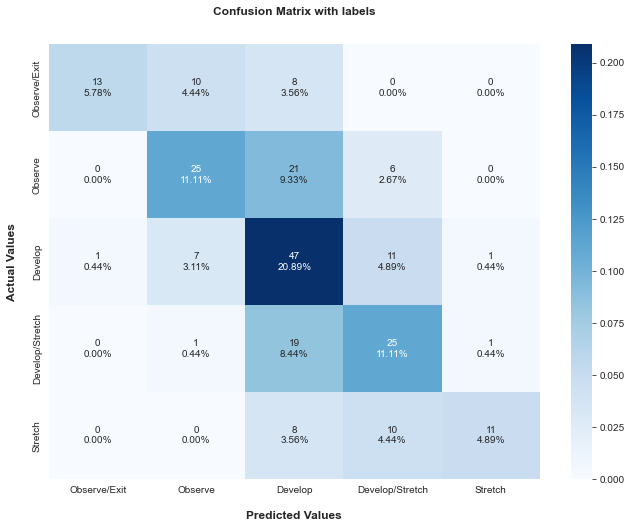

In [47]:
#print classification report and confusion matrix
print('MNB-test set')
conf_matrix(gs_multinomial_nb_tf, X_test, y_test)

In [48]:
#Pipline for SVC
pipe_rf_tf = Pipeline([
    ('tf', TfidfVectorizer()),
    ('sv', SVC())
])

params_sv_tf={
    'tf__stop_words':   [None, 'english'],
    'tf__max_features': [100, 500, 1000, 2000, 3000],
    'tf__ngram_range':  [(1,1), (1, 2),(2,3)],
    'tf__smooth_idf':   [True, False],
    'sv__gamma':        ['scale', 'auto'], 
    'sv__shrinking':    [True, False], 
    'sv__random_state': [66]
}
gs_sv_tf = GridSearchCV(pipe_rf_tf,
                        param_grid=params_sv_tf, 
                        cv=5,
                        n_jobs=2,
                        verbose=1)

gs_sv_tf.fit(X_train, y_train)

print(f'GridSearch Best Params: {gs_sv_tf.best_params_}')
print('Train Score:', gs_sv_tf.score(X_train, y_train))
print('Validation Score:', gs_sv_tf.score(X_val, y_val))
print('Test Score:', gs_sv_tf.score(X_test, y_test))

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
GridSearch Best Params: {'sv__gamma': 'scale', 'sv__random_state': 66, 'sv__shrinking': True, 'tf__max_features': 500, 'tf__ngram_range': (1, 1), 'tf__smooth_idf': True, 'tf__stop_words': 'english'}
Train Score: 0.9923780487804879
Validation Score: 0.3879310344827586
Test Score: 0.39111111111111113


In [49]:
#ypred = gs_sv_tf.predict(X_test)

In [50]:
#Confusion matrix for Random Forest
# print('SVC-Validation')
#print(conf_matrix_metrics(gs_multinomial_nb_tf, X_test, y_test))
# conf_matrix(gs_sv_tf, X_val, y_val)

SVC-test set
                 precision    recall  f1-score   support

   Observe/Exit       0.67      0.06      0.12        31
        Observe       0.52      0.31      0.39        52
        Develop       0.34      0.84      0.48        67
Develop/Stretch       0.52      0.28      0.37        46
        Stretch       1.00      0.03      0.07        29

       accuracy                           0.39       225
      macro avg       0.61      0.31      0.28       225
   weighted avg       0.55      0.39      0.33       225



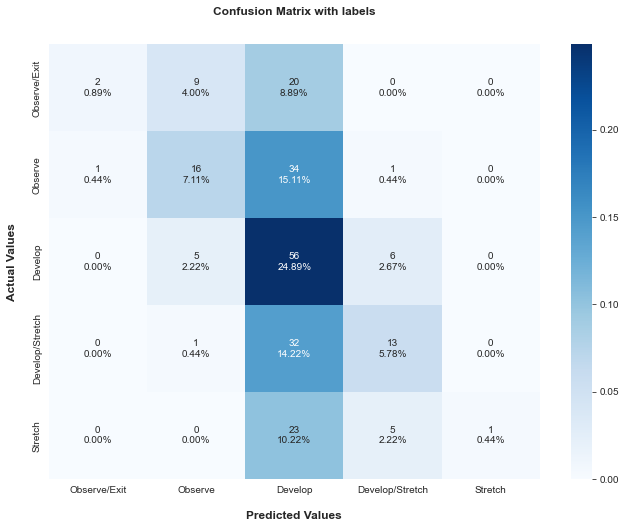

In [51]:
#print classification report and confusion matrix
print('SVC-test set')
conf_matrix(gs_sv_tf, X_test, y_test)

In [52]:
#Pipline for random forest
pipe_rf_tf = Pipeline([
    ('tf', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

params_rf_tf={
    'tf__stop_words':   [None, 'english'],
    'tf__max_features': [100, 500, 1000, 2000, 3000],
    'tf__ngram_range':  [(1,1), (1, 2),(2,3)],
    'tf__smooth_idf':   [True, False],
    'rf__n_estimators': [25, 50, 100], 
    'rf__criterion':    ['gini', 'entropy'],
    'rf__max_depth':    [5, 7, 9], 
    'rf__random_state': [66]
}
gs_rf_tf = GridSearchCV(pipe_rf_tf,
                        param_grid=params_rf_tf, 
                        cv=5,
                        n_jobs=2,
                        verbose=1)

gs_rf_tf.fit(X_train, y_train)

print('GridSearch Best Params:', gs_rf_tf.best_params_)
print('Train Score:', gs_rf_tf.score(X_train, y_train))
print('Validation Score:', gs_rf_tf.score(X_val, y_val))
print('Test Score:', gs_rf_tf.score(X_test, y_test))

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits
GridSearch Best Params: {'rf__criterion': 'entropy', 'rf__max_depth': 9, 'rf__n_estimators': 25, 'rf__random_state': 66, 'tf__max_features': 1000, 'tf__ngram_range': (1, 1), 'tf__smooth_idf': True, 'tf__stop_words': 'english'}
Train Score: 0.6844512195121951
Validation Score: 0.41379310344827586
Test Score: 0.3466666666666667


Random Forest-Test
                 precision    recall  f1-score   support

   Observe/Exit       0.50      0.06      0.11        31
        Observe       0.42      0.25      0.31        52
        Develop       0.32      0.87      0.47        67
Develop/Stretch       0.43      0.07      0.11        46
        Stretch       0.50      0.07      0.12        29

       accuracy                           0.35       225
      macro avg       0.43      0.26      0.23       225
   weighted avg       0.41      0.35      0.27       225



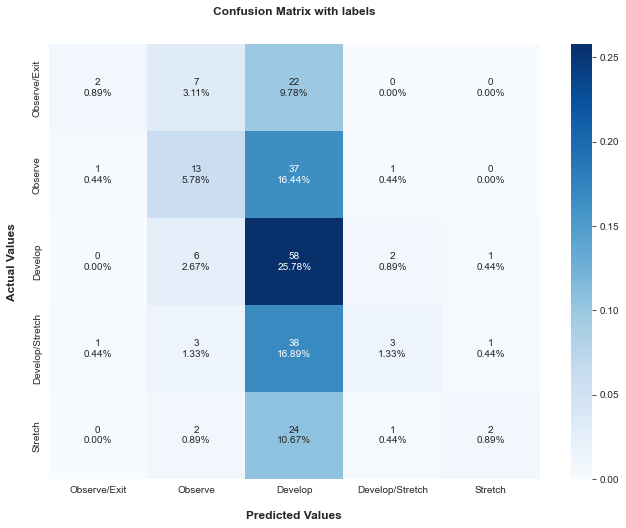

In [53]:
#print classification report and confusion matrix
print('Random Forest-Test')
conf_matrix(gs_rf_tf, X_test, y_test)